In [1]:
!pip install patchify

import os
import glob
import cv2
import numpy as np
import skimage.io
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from PIL import Image
import tensorflow as tf
import random
from google.colab.patches import cv2_imshow

np.random.seed(0) 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
PATH = '/content/drive/MyDrive/AV_split/'

TRAIN_PATH = PATH+'train/'
TRAIN_IMAGE_PATH = TRAIN_PATH + 'images/'
TRAIN_VESSEL_MASK_PATH = TRAIN_PATH + 'GT_vessel/'
TRAIN_ARTERY_MASK_PATH = TRAIN_PATH + 'GT_artery/'
TRAIN_VEIN_MASK_PATH = TRAIN_PATH + 'GT_vein/'

TEST_PATH = PATH+'test/'
TEST_IMAGE_PATH = TEST_PATH + 'images/'
TEST_VESSEL_MASK_PATH = TEST_PATH + 'GT_vessel/'
TEST_ARTERY_MASK_PATH = TEST_PATH + 'GT_artery/'
TEST_VEIN_MASK_PATH = TEST_PATH + 'GT_vein/'

PATCH_SIZE = 512

VEIN_COLOR = [0, 0, 255]      
ARTERY_COLOR = [255, 0, 0]     
BLACK_BG_COLOR = [0, 0, 0]
VESSEL_COLOR = [255, 255, 255]

In [3]:
def clahe_equalized(image):    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))    
    image_equalized = clahe.apply(image)

    return image_equalized

def preprocess_image(image, patch_size):
    image = image[70:970, 200:1255]

    image = image[:,:,1]
    image = clahe_equalized(image)

    image = (image).astype('uint8')
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) 

    SIZE_X = (image.shape[1]//patch_size)*patch_size 
    SIZE_Y = (image.shape[0]//patch_size)*patch_size     
    image = cv2.resize(image, (SIZE_X, SIZE_Y))
    
    image = image / 255.
    image = np.array(image)

    return image

def image_to_patch(image_path, patch_size):
    image_dataset = unpatched_image = []
    image = cv2.imread(image_path)

    image = preprocess_image(image, patch_size)
    patches_image = patchify(image, (patch_size, patch_size, 3), step=patch_size)
    unpatched_image = unpatchify(patches_image, image.shape)
    
    for i in range(patches_image.shape[0]):
        for j in range(patches_image.shape[1]):
            single_patch = patches_image[i,j,:,:]
            single_patch = (single_patch).astype('float32')
            image_dataset.append(single_patch[0])

    return image_dataset, unpatched_image

In [4]:
def preprocess_vessel_mask(mask, patch_size):
    thresh = 128
    mask = cv2.threshold(mask, thresh, 255, cv2.THRESH_BINARY)[1]

    mask = mask[70:970, 200:1255]
    
    SIZE_X = (mask.shape[1]//patch_size)*patch_size 
    SIZE_Y = (mask.shape[0]//patch_size)*patch_size     

    mask = cv2.resize(mask, (SIZE_X, SIZE_Y))
  
    mask = 255 - mask
    mask = mask / 255

    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return mask

def preprocess_vein_mask(image, patch_size):
    mask = preprocess_vessel_mask(image, patch_size)

    mask = (mask).astype('uint8')
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) * 255

    mask[np.all(mask == VESSEL_COLOR, axis=-1)] = VEIN_COLOR

    return (mask).astype('float32')

def preprocess_artery_mask(image, patch_size):
    mask = preprocess_vessel_mask(image, patch_size)

    mask = (mask).astype('uint8')
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) * 255

    mask[np.all(mask == VESSEL_COLOR, axis=-1)] = ARTERY_COLOR

    return (mask).astype('float32')

def merge_and_mask_labeling(vein_mask, artery_mask):
    result = cv2.add(vein_mask, artery_mask)

    mask_label = np.zeros(result.shape, dtype=np.uint8)
    mask_label[np.all(result == ARTERY_COLOR, axis=-1)] = 1
    mask_label[np.all(result == VEIN_COLOR, axis=-1)] = 2                                   

    return result, mask_label[:,:,0]                                            

def mask_to_patch(vein_path, artery_path, patch_size, visualize = False):
    mask_dataset = []

    vein_image = cv2.imread(vein_path, cv2.IMREAD_GRAYSCALE)
    vein_mask = preprocess_vein_mask(vein_image, patch_size)

    artery_image = cv2.imread(artery_path, cv2.IMREAD_GRAYSCALE)
    artery_mask = preprocess_artery_mask(artery_image, patch_size)

    if visualize:
        merged_mask, _ = merge_and_mask_labeling(vein_mask, artery_mask)
    else:
        _, merged_mask = merge_and_mask_labeling(vein_mask, artery_mask)

    patches_mask = patchify(merged_mask, (patch_size, patch_size), step=patch_size)
    unpatched_mask = unpatchify(patches_mask, merged_mask.shape)
    
    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch = patches_mask[i,j,:,:]
            single_patch = (single_patch).astype('float32')
            mask_dataset.append(single_patch)

    return mask_dataset, unpatched_mask

In [5]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_image_list = glob.glob(TRAIN_IMAGE_PATH + '/*.JPG')
train_image_list.sort()

train_vein_mask_list = glob.glob(TRAIN_VEIN_MASK_PATH + '/*.jpg')
train_vein_mask_list.sort()

train_artery_mask_list = glob.glob(TRAIN_ARTERY_MASK_PATH + '/*.jpg')
train_artery_mask_list.sort()

0.007843138 0.9843137
(2, 512, 512, 3)


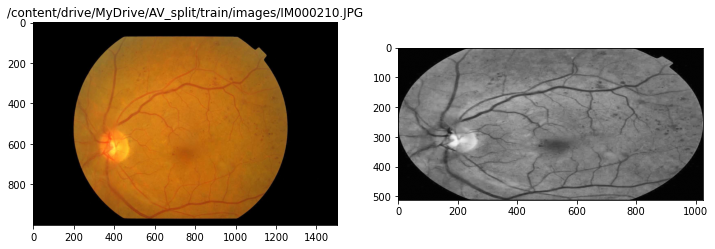

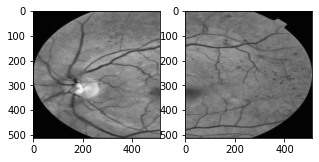

In [7]:
image_path = train_image_list[10]

original_image = cv2.imread(image_path)
patched_image_list, unpatched_image = image_to_patch(image_path, PATCH_SIZE)
patched_image = np.array(patched_image_list)

print(patched_image.min(), patched_image.max())
print(patched_image.shape)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title(image_path)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(unpatched_image, cmap='gray')

plt.show()

rows = 1
columns = patched_image.shape[0]

fig = plt.figure(figsize=(5, 5))
for i in range(1, (rows * columns + 1)):
    fig.add_subplot(rows, columns, i)
    img = patched_image[i-1]
    plt.imshow(img, cmap='gray')

plt.show()

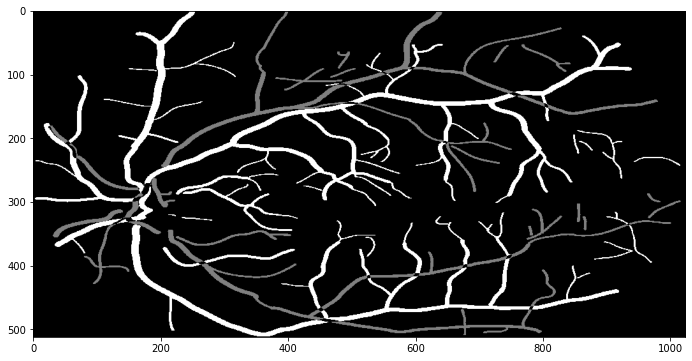

0.0 2.0
(2, 512, 512)
[0. 1. 2.]


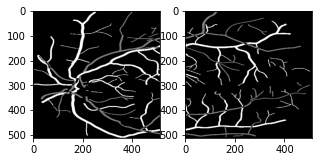

In [9]:
vein_mask_path = train_vein_mask_list[10]
artery_mask_path = train_artery_mask_list[10]

original_vein_mask = cv2.imread(vein_mask_path, cv2.IMREAD_GRAYSCALE)
original_artery_mask = cv2.imread(artery_mask_path, cv2.IMREAD_GRAYSCALE)

patched_mask_list, unpatched_mask = mask_to_patch(vein_mask_path, artery_mask_path, PATCH_SIZE, visualize = False)
patched_mask = np.array(patched_mask_list)

plt.figure(figsize=(12, 6))
plt.imshow(unpatched_mask, cmap='gray')
plt.show()

print(patched_mask.min(), patched_mask.max())
print(patched_mask.shape)
print(np.unique(patched_mask))

rows = 1
columns = patched_mask.shape[0]

fig = plt.figure(figsize=(5, 5))
for i in range(1, (rows * columns + 1)):
    fig.add_subplot(rows, columns, i)
    img = patched_mask_list[i-1] 
    plt.imshow(img,cmap='gray')

plt.show()

In [10]:
train_image_dataset = []
train_mask_dataset = []

for image_path in train_image_list:
    patched_image, unpatched_image = image_to_patch(image_path, PATCH_SIZE)
    train_image_dataset += patched_image

for (vein_mask_path, artery_mask_path) in zip(train_vein_mask_list, train_artery_mask_list):
    patched_mask, unpatched_mask = mask_to_patch(vein_mask_path, artery_mask_path, PATCH_SIZE, visualize = False)
    train_mask_dataset += patched_mask

train_image_dataset = np.array(train_image_dataset)
train_mask_dataset = np.array(train_mask_dataset)

print(train_image_dataset.shape)
print(train_mask_dataset.shape)
print(train_image_dataset.max(), train_mask_dataset.max())
print(train_image_dataset.min(), train_mask_dataset.min())

(72, 512, 512, 3)
(72, 512, 512)
1.0 2.0
0.003921569 0.0


In [11]:
from tensorflow.keras.utils import to_categorical

n_classes = len(np.unique(train_mask_dataset))
mask_categories = to_categorical(train_mask_dataset, num_classes=n_classes)

print(np.unique(mask_categories))
print(mask_categories.shape)

[0. 1.]
(72, 512, 512, 3)


<Figure size 360x360 with 0 Axes>

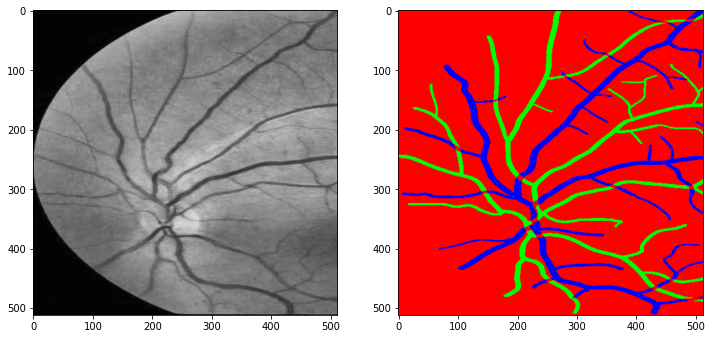

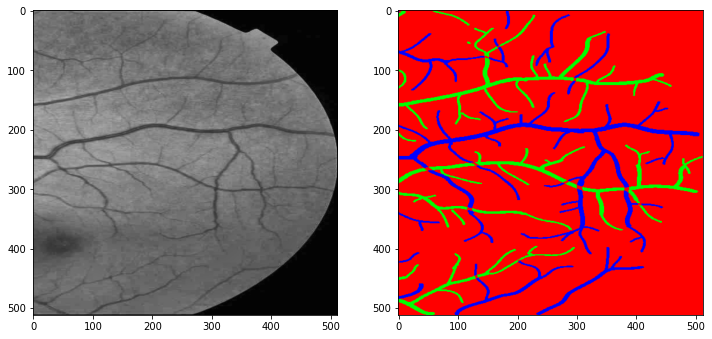

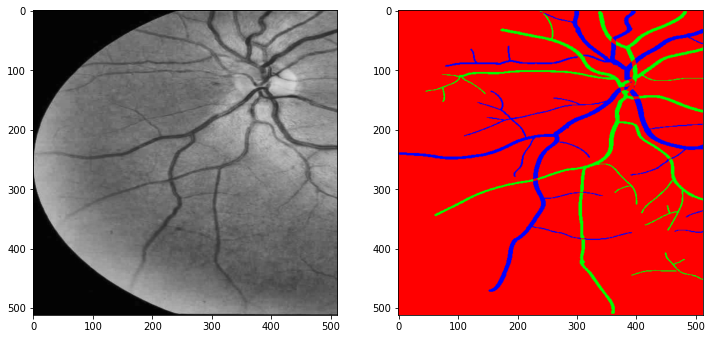

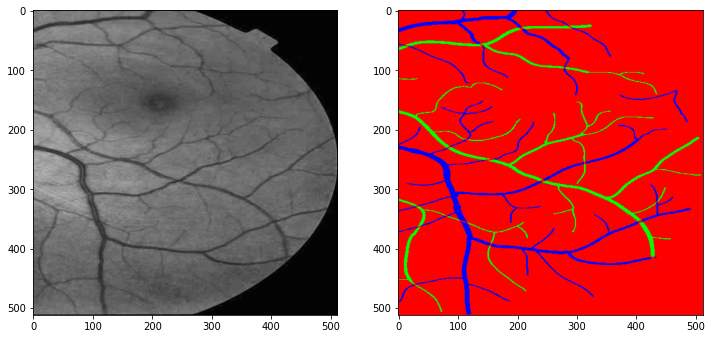

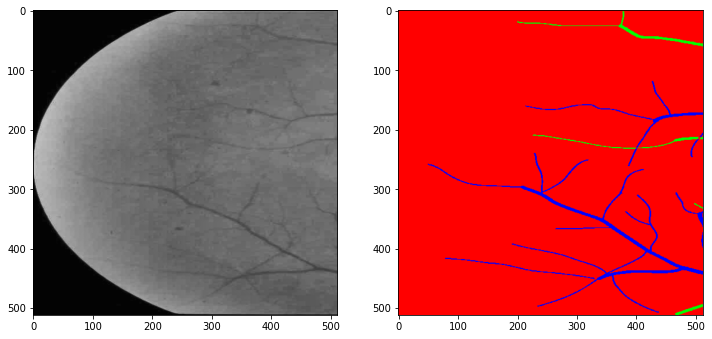

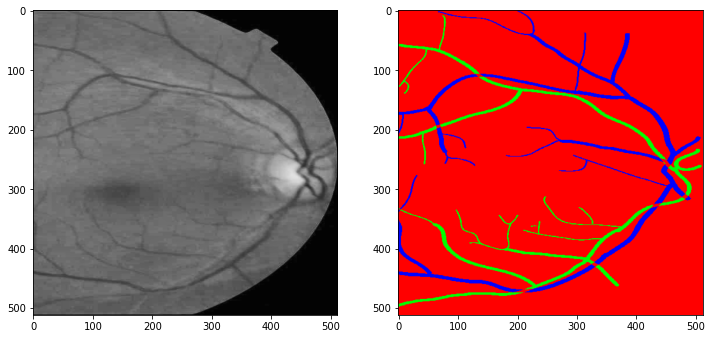

In [12]:
rows = 3
columns = 2

fig = plt.figure(figsize=(5, 5))
for i in range(1, (rows * columns + 1)):
    plt.figure(figsize=(12, 6))

    plt.subplot(121)
    plt.imshow(train_image_dataset[i-1])

    plt.subplot(122)
    plt.imshow(mask_categories[i-1])
    
    plt.show()
plt.show()

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_image_dataset, mask_categories, test_size=0.2, random_state=0)

In [14]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(57, 512, 512, 3) (57, 512, 512, 3)
(15, 512, 512, 3) (15, 512, 512, 3)


In [15]:
IMG_HEIGHT = x_train.shape[1]
IMG_WIDTH  = x_train.shape[2]
IMG_CHANNELS = x_train.shape[3]

print(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

512 512 3


In [16]:
"""
Standard Unet
Model encapsulated in a class for easy testing of various loss functions and optimizers. 
"""
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    # Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [17]:
from keras.optimizers import Adam

metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 512, 512, 16  0           ['conv2d[0][0]']                 
                                )                                                             

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [18]:
batch_size = 3
epoch = 150
train_steps = len(x_train)//batch_size
valid_steps = len(x_test)//batch_size

print(train_steps, valid_steps)

19 5


In [19]:
history = model.fit(x_train, y_train, 
                    batch_size = 3, 
                    verbose = 1, 
                    epochs = epoch, 
                    validation_data = (x_test, y_test), 
                    steps_per_epoch = 10,
                    shuffle = False)

Epoch 1/150
10/10 [==============================] - 16s 258ms/step - loss: 0.8082 - accuracy: 0.7592 - jacard_coef: 0.3417 - val_loss: 0.8130 - val_accuracy: 0.8865 - val_jacard_coef: 0.2970
Epoch 2/150
10/10 [==============================] - 2s 180ms/step - loss: 0.6659 - accuracy: 0.8313 - jacard_coef: 0.4483 - val_loss: 0.7558 - val_accuracy: 0.9004 - val_jacard_coef: 0.3219
Epoch 3/150
10/10 [==============================] - 2s 165ms/step - loss: 0.6049 - accuracy: 0.8703 - jacard_coef: 0.5218 - val_loss: 0.7298 - val_accuracy: 0.9009 - val_jacard_coef: 0.3346
Epoch 4/150
10/10 [==============================] - 2s 181ms/step - loss: 0.5579 - accuracy: 0.8837 - jacard_coef: 0.5360 - val_loss: 0.6532 - val_accuracy: 0.9009 - val_jacard_coef: 0.3782
Epoch 5/150
10/10 [==============================] - 2s 164ms/step - loss: 0.5298 - accuracy: 0.8810 - jacard_coef: 0.5712 - val_loss: 0.6423 - val_accuracy: 0.9009 - val_jacard_coef: 0.3806
Epoch 6/150
10/10 [=========================

In [77]:
# IOU
y_pred=model.predict(x_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

# Using built in keras function for IoU
from tensorflow.keras.metrics import MeanIoU

n_classes = len(np.unique(train_mask_dataset))
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 0s 67ms/step
Mean IoU = 0.43681636


In [84]:
test_image_list = glob.glob(TEST_IMAGE_PATH + '/*.JPG')
test_image_list.sort()

test_vein_mask_list = glob.glob(TEST_VEIN_MASK_PATH + '/*.jpg')
test_vein_mask_list.sort()

test_artery_mask_list = glob.glob(TEST_ARTERY_MASK_PATH + '/*.jpg')
test_artery_mask_list.sort()

1/1 [==============================] - 0s 24ms/step
(512, 512)
[0 1 2]


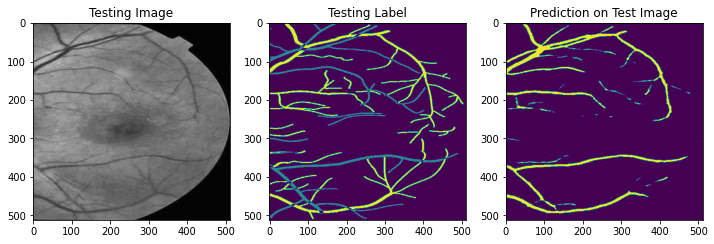

In [93]:
import random

test_img_number = random.randint(0, len(x_test))
test_img = x_test[test_img_number]
ground_truth = y_test_argmax[test_img_number]

test_img_input = np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img = np.argmax(prediction, axis=3)[0,:,:]

print(predicted_img.shape)
print(np.unique(predicted_img))

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on Test Image')
plt.imshow(predicted_img)
plt.show()